# step 46. Optimizer

### optimizer class
* 매개변수 갱신을 위한 기반클래스
* 구체적인 최적화 기법은 optimizer 클래스를 상속한 곳에서 구현한다

In [ ]:
class Optimizer:
    def __init__(self):
        self.target = None           # 업데이트 대상 : Model 또는 Layer
        self.hooks = []
        
    def setup(self, target):         # setup 메서드에서 업데이트 타겟 설정
        self.target = target
        return self
    
    def update(self):
        # gradient가 None이 아닌 모든 파라미터를 모은다.
        params = [p for p in self.target.params() if p.grad is not None]
        
        # 전처리(option) : weight decay / gradient clipping 등
        for f in self.hooks:
            f(params)
        
        # 매개변수 갱신
        for param in params:
            self.update_one(param)
    
    def update_one(self, params):     # 구체적인 업데이트 방식은 자식클래스에서 재정의
        raise NotImplementedError()
    
    def add_hook(self, f):
        self.hooks.append(f)

### SGD class

In [ ]:
class SGD(Optimizer):
    def __init__(self, lr = 0.01):
        super().__init__()
        self.lr = lr
        
    def update_one(self, param):
        param.data -= self.lr * param.grad.data

### MomentumSGD

In [ ]:
import numpy as np

class MomentumSGD(Optimizer):
    def __init__(self, lr = 0.01, momentum = 0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {}
        
    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)
            
        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v

In [2]:
import numpy as np
from dezero import Variable
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# data
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# parameter setting
lr = 0.2
iters = 10000
hidden_size = 10

# model define
model = MLP((hidden_size, 1))
optimizer = optimizers.MomentumSGD(lr).setup(model)

# learning
for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()
    
    optimizer.update()
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.07743134827996008)
variable(0.07544895146731474)
variable(0.0746326030585864)
variable(0.07420983776361521)
variable(0.07397000396385317)
variable(0.07383179319278566)
variable(0.07375198316276851)
variable(0.07370578149495666)
variable(0.07367887538341852)


# step 47. Softmax & Cross Entropy

In [ ]:
# add utility function - get_item()
# 다차원 배열을 slicing하는 기능

import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3], [4,5,6]]))
y = F.get_item(x, 1)
print(y)

y.backward()
print(x.grad())

indices = np.array([0,0,1])
y = F.get_item(x, indices)
print(y)

# Variable.__getitem__ = F.get_item

y = x[1]
print(y)

y = x[:,2]
print(y)

### implement softmax function

In [2]:
from dezero.models import MLP
import numpy as np

model = MLP((10,3))

x = np.array([[0.2,-0.4],[0.3,0.5],[1.3,-3.2]])
y = model(x)
print(y)

variable([[-0.54224404  0.09685547  0.52286398]
          [-0.45705156  0.09128976  0.65779778]
          [-0.7642369   0.21514968  0.05824683]])


In [ ]:
from dezero import Variable. as_variable
import dezero.functions as F

def softmax1d(x):
    x = as_variable(x)
    y = F.exp(x)
    sum_y = F.sum(y)
    return y / sum_y

x = Variable(np.array([[0.2, -0.4]]))
y = model(x)
p = softmax1d(y)
print(y)
print(p)

In [ ]:
# softmax for batch computation
def softmax_simple(x, axis = 1):
    y = as_variable(x)
    y = exp(x)
    sum_y = sum(y, axis = axis, keepdims = True)
    eps = 1e-7
    return y / (sum_y + eps)

### implement cross entropy

In [ ]:
def softmax_cross_entropy_simple(x, t):
    x, t = as_variable(x), as_variable(t)
    N = x.shape[0]
    
    p = softmax(x)
    p = clip(p, 1e-15, 1.0)
    log_p = log(p)
    tlog_p = log_p[np.arange(N), t.data]
    y = -1 * sum(tlog_p) / N
    return y

In [3]:
import numpy as np
import dezero.functions as F

X = np.array([[0.2,-0.4], [0.3, 0.5], [1.3,-3.2]])
t = np.array([2, 0, 1])
y = model(x)
loss = F.softmax_cross_entropy(y, t)
print(loss)

variable(1.0828371573902766)


# step 48. Multi class classification

### spiral dataset

(300, 2)
(300,)


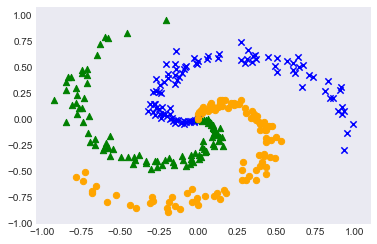

[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


In [3]:
import dezero
import matplotlib.pyplot as plt

x, t = dezero.datasets.get_spiral(train = True)
print(x.shape)
print(t.shape)

# Plot data points of the dataset
plt.style.use("seaborn-dark")

N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40,  marker=markers[c], c=colors[c])
plt.show()

print(x[10], t[10])
print(x[110], t[110])

In [7]:
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# hyperparameter setting
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# data load, create model, set optimizer
x, y = dezero.datasets.get_spiral(train = True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # shuffle idx of dataset
    index = np.random.permutation(data_size)
    sum_loss = 0
    
    for i in range(max_iter):
        # minibatch
        batch_index = index[i * batch_size : (i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]
        
        # calculate gradient & parameter update
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t) # batch내 평균손실 
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(batch_t) # batch size를 곱해 배치 총손실 구함
        
    # print
    avg_loss = sum_loss / data_size # epoch의 평균손실
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

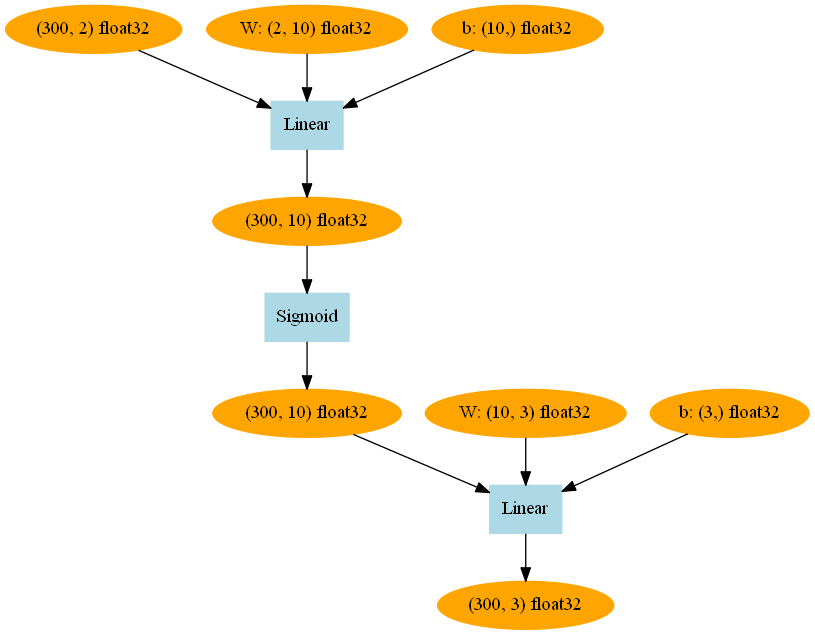

In [13]:
model.plot(x)

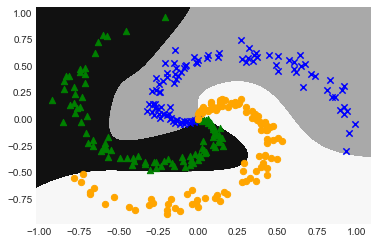

In [10]:
# Plot boundary area the model predict
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.no_grad():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40,  marker=markers[c], c=colors[c])
plt.show()

# step 49. Dataset class, preprocessing

In [ ]:
import numpy as np

class Dataset:
    def __init__(self, train = True):
        self.train = train
        self.data = None
        self.label = None
        self.prepare()
        
    # 파이썬 특수 메서드로, x[0]이나 x[1]처럼 괄호를 사용해 접근할 떄의 동작을 정의
    # 슬라이스는 지원하지 않음
    def __getitem__(self, index):
        assert np.isscaler(index)
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index], self.label[index]
        
    def __len__(self):
        return len(self.data)
    
    # 하위클래스에서 다시 정의해줄 것임
    def prepare(self):
        pass

In [ ]:
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

In [ ]:
import dezero

train_set = dezero.datasets.Spiral(train = True)
print(train_set[0])
print(len(train_set))

In [ ]:
class BigData(Dataset):
    def __getitem__(index):
        x = np.load('data/{}.npy'.format(index))
        t = np.load('label/{}.npy'.format(index))
        return x, t
    
    def __len__():
        return 1000000

### prepare mini batch

In [ ]:
train_set = dezero.datasets.Spiral()

batch_index = [0, 1, 2]
batch = [train_set[i] for i in batch_index]

x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

In [6]:
import math
import numpy as np
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero.models import MLP


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# 데이터와 모델 준비
train_set = dezero.datasets.Spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # Create minibatch
        batch_index = index[i * batch_size : (i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index]
        batch_x = np.array([example[0] for example in batch])
        batch_t = np.array([example[1] for example in batch])

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

epoch 1, loss 1.13
epoch 2, loss 1.05
epoch 3, loss 0.95
epoch 4, loss 0.92
epoch 5, loss 0.87
epoch 6, loss 0.89
epoch 7, loss 0.84
epoch 8, loss 0.78
epoch 9, loss 0.80
epoch 10, loss 0.79
epoch 11, loss 0.78
epoch 12, loss 0.76
epoch 13, loss 0.77
epoch 14, loss 0.76
epoch 15, loss 0.76
epoch 16, loss 0.77
epoch 17, loss 0.78
epoch 18, loss 0.74
epoch 19, loss 0.74
epoch 20, loss 0.72
epoch 21, loss 0.73
epoch 22, loss 0.74
epoch 23, loss 0.77
epoch 24, loss 0.73
epoch 25, loss 0.74
epoch 26, loss 0.74
epoch 27, loss 0.72
epoch 28, loss 0.72
epoch 29, loss 0.72
epoch 30, loss 0.73
epoch 31, loss 0.71
epoch 32, loss 0.72
epoch 33, loss 0.72
epoch 34, loss 0.71
epoch 35, loss 0.72
epoch 36, loss 0.71
epoch 37, loss 0.71
epoch 38, loss 0.70
epoch 39, loss 0.71
epoch 40, loss 0.70
epoch 41, loss 0.71
epoch 42, loss 0.70
epoch 43, loss 0.70
epoch 44, loss 0.70
epoch 45, loss 0.69
epoch 46, loss 0.69
epoch 47, loss 0.71
epoch 48, loss 0.70
epoch 49, loss 0.69
epoch 50, loss 0.69
epoch 51,

### preprocessing

In [ ]:
import numpy as np

class Dataset:
    def __init__(self, train = True, transform = None, target_transform = None):
        self.train = train
        # 데이터 변환 플래그 추가
        self.transform = transform # 파이썬 함수와 같이 호출 가능한 객체를 받음
        self.target_transform = target_transform
        if self.transform is None:
            self.transform = lambda x:x
        if self.target_transform is None:
            self.target_transform = lambda x:x
        
        self.data = None
        self.label = None
        self.prepare()
        
    def __getitem__(self, index):
        assert np.isscaler(index)
        if self.label is None:
            return self.transform(self.data[index]), None
        else:
            return self.transform(self.data[index]),\
                    self.target_transform(self.label[index])
        
    def __len__(self):
        return len(self.data)
    
    # 하위클래스에서 다시 정의해줄 것임
    def prepare(self):
        pass

In [ ]:
# 변환 사용예시
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform = f)

In [7]:
import dezero
from dezero import transforms

# 정규화
f = transforms.Normalize(mean = 0.0, std = 2.0)
train_set = dezero.datasets.Spiral(transform = f)

# 여러 변환 연달아 수행
f = transforms.Compose([transforms.Normalize(mean = 0.0, std = 2.0),
                        transforms.AsType(np.float64)])